In [161]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
import torch, pickle, sys
sys.path.append('/home/dgotzens/scripts/')
import pdfdefaults as pdf
# setup
nfft = 2**12

pi = 3.141592653589 
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76_009_996_288.0, 80_289_505_280.0
t_chirp = 0.000_064_890_002_249_740_060
hertz_per_meter = (f_end-f_start) / t_chirp / lightspeed
bins_per_meter = nfft / maxdist

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
params = pickle.load(open(folder+'feparams.pkl', 'rb'))
tx,ty,rx,ry = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY']

In [34]:
dists = (2,8,18,32)
N = len(dists)
K = 192
maxgain = torch.empty(K,N)
exact_dists = torch.empty(K,N)
folder = '/home/dgotzens/recording/'

for n,dist in enumerate(dists):
    data = torch.load(f'{folder}a{dist:02d}_data.pt')
    M,K,L = data.shape
    print(f'loaded data for {dist}m. processing...')

    bp_start = int((dist-0.5)*bins_per_meter)
    bp_len = int(1*bins_per_meter)

    window = torch.hann_window(M)
    window = window / window.sum()

    gain = torch.empty(K,L)
    m_refl = torch.empty(K,L, dtype=int)
    for l in range(L):
        fft = torch.fft.fft(window[:,None]*data[:,:,l], n=nfft, dim=0)
        m_refl[:,l] = fft[bp_start:bp_start+bp_len,:].abs().argmax(0) + bp_start
        gain[:,l] = fft.abs()[m_refl[:,l], range(K)]
    maxgain[:,n] = gain.max(1).values
    idx = gain.max(1).indices
    exact_dists[:,n] = m_refl[range(K),idx]/bins_per_meter

loaded data for 2m. processing...
loaded data for 8m. processing...
loaded data for 18m. processing...
loaded data for 32m. processing...


In [177]:
pdf.setup()
ex = 2
gain_1m = (1/exact_dists**ex*maxgain).sum(1) / ((1/exact_dists**ex)**2).sum(1)

k=gain_1m.argmax()
plt.figure(figsize=(0.5*pdf.a4_textwidth, 0.4*pdf.a4_textwidth), layout='constrained')
plt.plot(torch.arange(1.5,35,0.5), gain_1m[k]/torch.arange(1.5,35,0.5)**ex, 'k:', label='data')
plt.scatter(exact_dists[k,:], maxgain[k,:], label='regression')
plt.title('Linear Regression for channel 0')
plt.gca().xaxis.set_major_formatter(EngFormatter('m'))
plt.grid()
plt.xlabel('distance')
plt.ylabel('amplitude')
plt.savefig('/home/dgotzens/thesis/figures/ch0_amplitude_linreg.pdf')


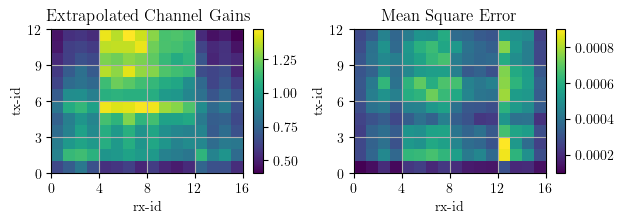

In [181]:
Ntx,Nrx = 12,16
gainmatrix = gain_1m.unflatten(0,(Ntx,Nrx))
mse = (gain_1m[:,None]/exact_dists**2 - maxgain).square().mean(1)
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, (left,right) = plt.subplots(1,2,layout='tight')
fig.set_size_inches(pdf.a4_textwidth,0.4*pdf.a4_textwidth)
im1 = left.pcolormesh(gainmatrix)
left.set_yticks(range(0,Ntx+1,3))
left.set_xticks(range(0,Nrx+1,4))
left.set_ylabel('tx-id')
left.set_xlabel('rx-id')
left.set_title('Extrapolated Channel Gains')
left.set_aspect('equal')
left.grid()

divider = make_axes_locatable(left)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1 , cax=cax, orientation='vertical')

im2 = right.pcolormesh(mse.unflatten(0,(Ntx,Nrx)))
right.grid()
right.set_yticks(range(0,Ntx+1,3))
right.set_xticks(range(0,Nrx+1,4))
right.set_ylabel('tx-id')
right.set_xlabel('rx-id')
right.set_title('Mean Square Error')
right.set_aspect('equal')

divider = make_axes_locatable(right)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

fig.savefig('/home/dgotzens/thesis/figures/amplitude_linreg.pdf')

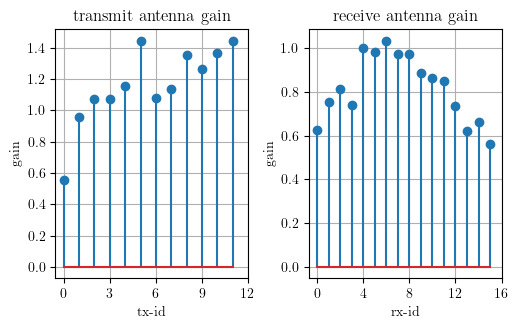

In [202]:
Atx = gainmatrix[:,4]
Arx = (gainmatrix/Atx[:,None]).mean(0)
fig, (left,right) = plt.subplots(1,2,layout='constrained')
fig.set_size_inches(0.8*pdf.a4_textwidth, 0.5*pdf.a4_textwidth)
left.stem(range(Ntx),Atx)
left.set_ylabel('gain')
left.set_xlabel('tx-id')
left.set_xticks(range(0,Ntx+1,Ntx//4))
left.set_title('transmit antenna gain')
left.grid()

right.stem(range(Nrx),Arx)
right.set_ylabel('gain')
right.set_xlabel('rx-id')
right.set_xticks(range(0,Nrx+1,Nrx//4))
right.set_title('receive antenna gain')
right.grid()

fig.savefig('/home/dgotzens/thesis/figures/antenna_gains.pdf')